<a href="https://colab.research.google.com/github/Reenav-Ray/Emotion-Classifier/blob/main/Mars_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import zipfile

with zipfile.ZipFile("Merged_Full_zip.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")


FileNotFoundError: [Errno 2] No such file or directory: 'Merged_Full_zip.zip'

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Where your full dataset is stored
SOURCE_DIR = "dataset/Merged_Full"

# Emotion map
emotion_map = {
    "01": "Neutral", "02": "Calm", "03": "Happy", "04": "Sad",
    "05": "Angry", "06": "Fearful", "07": "Disgust", "08": "Surprised"
}

# Step 1: Get file list and labels
all_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(".wav")]
labels = [f.split("-")[2] for f in all_files]  # extract emotion ID from filename

# Step 2: Use StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(all_files, labels))

train_files = np.array(all_files)[train_idx]
val_files = np.array(all_files)[val_idx]

# Step 3: Create output folders
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)

# Step 4: Move files
for f in train_files:
    shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join("data/train", f))
for f in val_files:
    shutil.copy(os.path.join(SOURCE_DIR, f), os.path.join("data/val", f))

print(f"✅ Stratified split complete: {len(train_files)} train, {len(val_files)} val")


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/Merged_Full'

In [ ]:
!pip install librosa soundfile joblib scikit-learn xgboost -q


In [ ]:
import os
import numpy as np
import librosa
import joblib
import soundfile as sf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
emotion_map = {
    "01": "Neutral", "02": "Calm", "03": "Happy", "04": "Sad",
    "05": "Angry", "06": "Fearful", "07": "Disgust", "08": "Surprised"
}

def extract_label(filename):
    try:
        return emotion_map.get(filename.split("-")[2], "Unknown")
    except:
        return "Unknown"

In [ ]:
def extract_features(file_path, sr=16000, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)

    # Amplitude envelope
    amplitude_envelope = np.max(np.abs(y))

    # Root mean square (RMS) energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Zero crossing rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))

    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_mean = np.mean(mel_db, axis=1)
    mel_std = np.std(mel_db, axis=1)

    # Spectral centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    # Spectral bandwidth
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))

    # Combine all features
    features = np.concatenate((
        [amplitude_envelope, rms, zcr, centroid, bandwidth],
        mfcc_mean, mfcc_std,
        mel_mean, mel_std
    ))

    return features

In [ ]:
def load_dataset(directory):
    X, y = [], []
    for fname in os.listdir(directory):
        if fname.endswith(".wav"):
            fpath = os.path.join(directory, fname)
            label = extract_label(fname)
            if label != "Unknown":
                features = extract_features(fpath)
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [ ]:
X_train, y_train = load_dataset("data/train")
X_val, y_val = load_dataset("data/val")

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train_scaled, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model.predict(X_val_scaled)
print("✅ Accuracy:", round(accuracy_score(y_val_enc, y_pred)*100, 2), "%")
print("✅ F1 Score:", round(f1_score(y_val_enc, y_pred, average='weighted')*100, 2), "%")
print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

✅ Accuracy: 97.48 %
✅ F1 Score: 97.48 %
              precision    recall  f1-score   support

       Angry       0.99      0.98      0.99       132
        Calm       0.96      0.99      0.97       132
     Disgust       1.00      1.00      1.00        63
     Fearful       0.98      0.98      0.98       126
       Happy       0.98      0.94      0.96       135
     Neutral       1.00      0.98      0.99        63
         Sad       0.96      0.97      0.97       136
   Surprised       0.94      0.96      0.95        85

    accuracy                           0.97       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.97      0.97       872



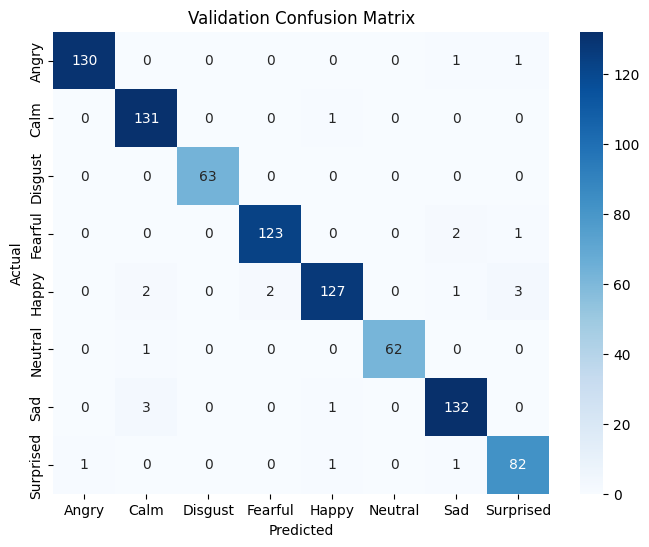

In [ ]:
cm = confusion_matrix(y_val_enc, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

In [ ]:
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
from google.colab import files
files.download("model.pkl")
files.download("scaler.pkl")
files.download("label_encoder.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>